# 時間序列分析股價

## 載入套件與初始設定

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
import warnings
warnings.filterwarnings('ignore')

In [64]:
# 股票列表
stock_list = pd.read_excel('stock_list.xlsx')  
today = datetime.date.today()
dateStart = (today - datetime.timedelta(days=365*4)).strftime('%Y-%m-%d')    # 載入三年資料
dateEnd = today.strftime('%Y-%m-%d')  

## 載入股票資料

[*********************100%%**********************]  1 of 1 completed


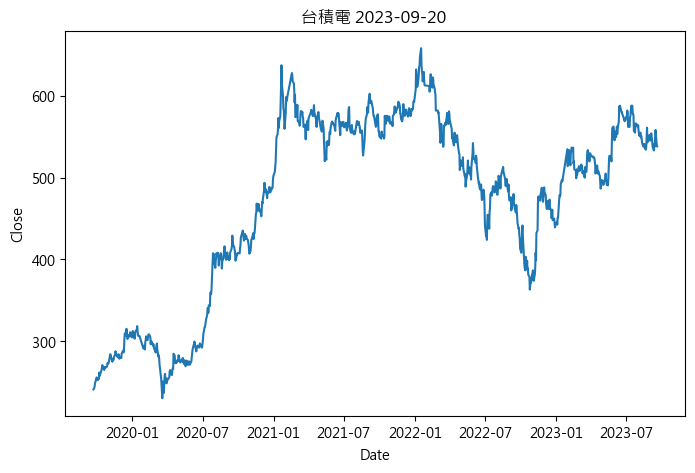

In [65]:
target_stock = '2330'
df = yf.download(f'{target_stock}.TW', start=dateStart, end=dateEnd)
df_close = df[['Adj Close']].copy()
df_close.columns = ['Close']
stock_name = stock_list[stock_list['代號']==int(target_stock)]['股票名稱'].values[0]
plt.figure(figsize=(8, 5))
plt.title(f'{stock_name} {today} ')
sns.lineplot(x=df_close.index, y='Close', data=df_close );

## 定態測試(Augmented Dickey–Fuller Test for Stationarity)

In [66]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_close)
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')
if result[1] < 0.05:
    print('p < 0.05 ==> 定態')
else:
    print('p > 0.05 ==> 非定態')

ADF統計量: -2.015156085067799
p value: 0.27996747670594235
滯後期數(Lags): 1
資料筆數: 970
p > 0.05 ==> 非定態


## SARIMAX (Seasonal ARIMA) 演算法

### 一次差分(First-order Differencing)

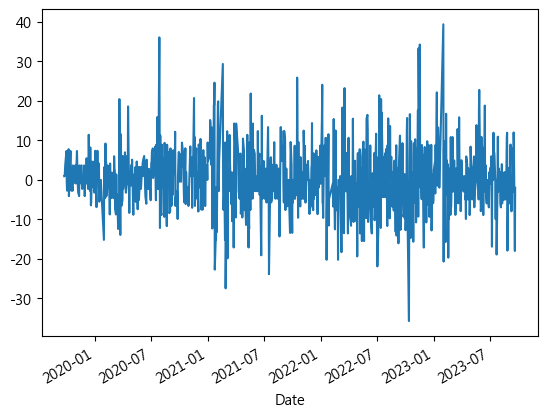

In [67]:
df_diff = pd.DataFrame()
df_diff['Adj Close'] = df['Adj Close'].copy()
df_diff['diff'] = df['Adj Close'] - df['Adj Close'].shift(1)
df_diff.dropna(inplace=True)
df_diff['diff'].plot();

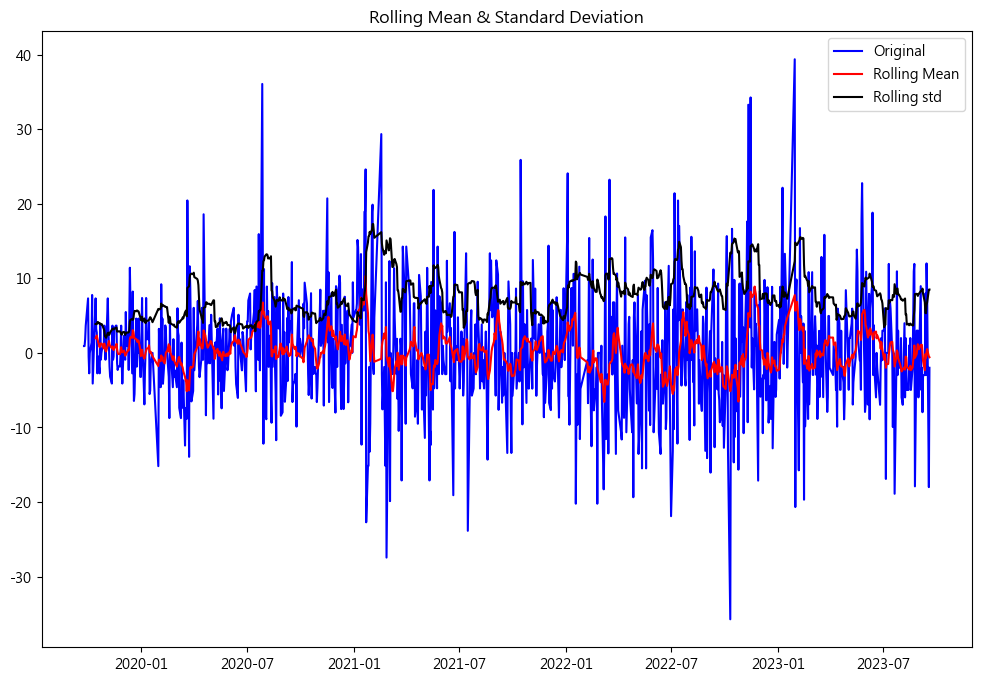

Results of Dickey-Fuller Test:
Test statistic                -29.689689
p-value                         0.000000
#Lags Used                      0.000000
Number of Obervations Used    970.000000
Critical Value(1%)             -3.437109
Critical Value(5%)             -2.864524
Critical Value(10%)            -2.568359
dtype: float64


In [68]:

def test_stationarity(timeseries):
    #Determing rolling statistics:
    rolmean=timeseries.rolling(window=12).mean()
    rolstd=timeseries.rolling(window=12).std()
    
    #Plot rolling statistics:
    fig=plt.figure(figsize=(12,8))
    orig=plt.plot(timeseries,color='blue',label='Original')
    mean=plt.plot(rolmean,color='red',label='Rolling Mean')
    std=plt.plot(rolstd,color='black',label='Rolling std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Perform Dickey-Fuller test:
    # Dickey-Fuller test is used to determine whether a unit root (a feature that can cause 
    # issues in statistical inference) is present in an autoregressive model.
    print('Results of Dickey-Fuller Test:')
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test statistic','p-value','#Lags Used','Number of Obervations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value(%s)'%key]=value
    print(dfoutput)
# difference it, subtract the previous value from the current value
test_stationarity(df_diff['diff'].dropna(inplace=False))

### 使用ADF檢定

In [69]:
result = adfuller(df_diff['diff'])
print(F'ADF統計量: {result[0]}\np value: {result[1]}' + \
      f'\n滯後期數(Lags): {result[2]}\n資料筆數: {result[3]}')

ADF統計量: -29.68968868475218
p value: 0.0
滯後期數(Lags): 0
資料筆數: 970


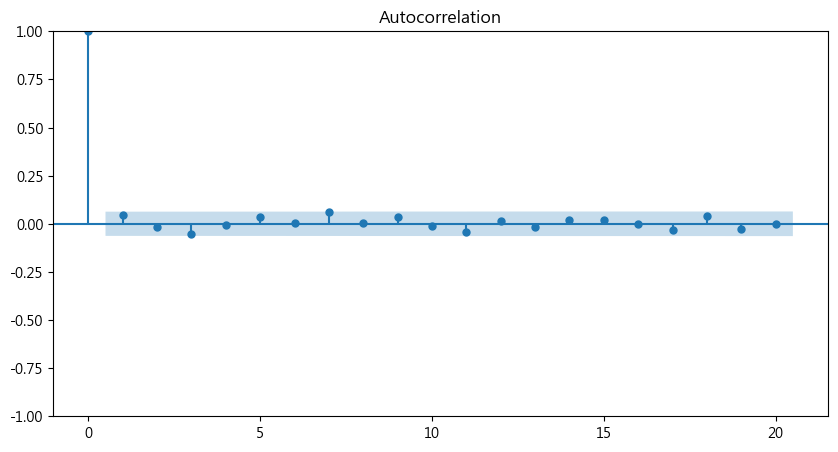

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(df_diff['diff'], lags=20)
fig.set_size_inches(10, 5)

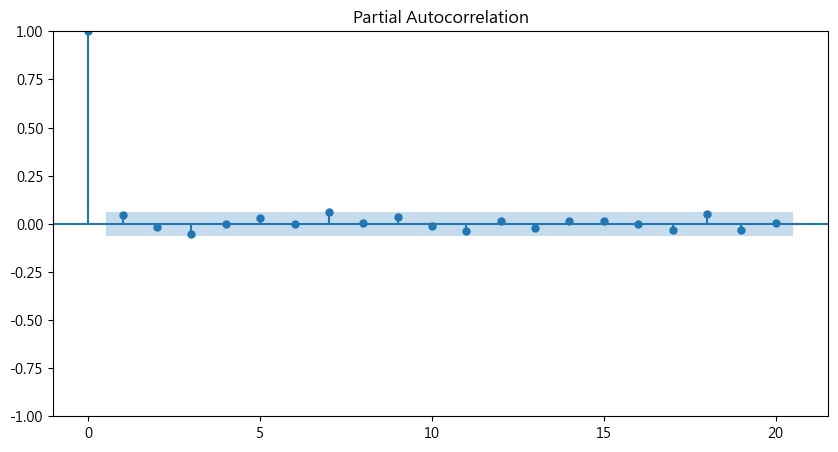

In [71]:
fig = plot_pacf(df_diff['diff'], lags=20, method='ywm')
fig.set_size_inches(10, 5)

### SARIMA(p,d,q)x(P,D,Q)

In [72]:
# 預測 30 天
pred_period = 30

# 資料分割
X_train, X_test = train_test_split(df_diff, test_size=pred_period, shuffle=False)

# SARIMAX

ar_diff=sm.tsa.statespace.SARIMAX(X_train[['Adj Close']],order=(1, 2, 1),seasonal_order=(1,2,1,7))
model_diff=ar_diff.fit()

pred = model_diff.predict(X_train.shape[0] , X_train.shape[0] + pred_period - 1, dynamic= True)
pred[:10]

941    547.690015
942    545.552501
943    537.508462
944    533.354137
945    534.865615
946    535.501859
947    533.678580
948    532.010026
949    529.801214
950    526.429579
Name: predicted_mean, dtype: float64

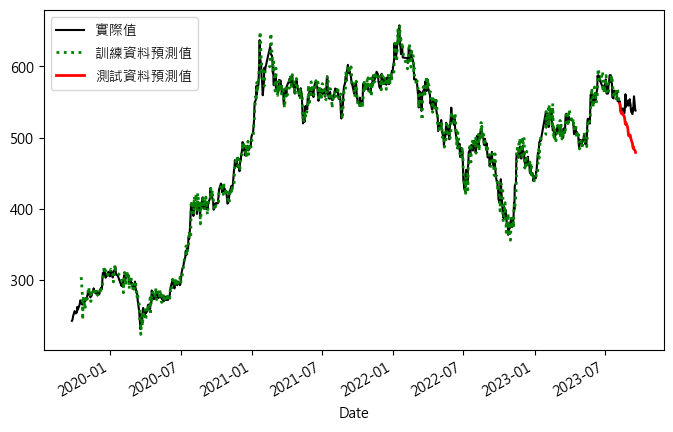

In [73]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

df_diff['Adj Close'].plot(color='black', linestyle='-', label='實際值')
model_diff.fittedvalues.iloc[15:].plot(color='green', linestyle=':', lw=2, label='訓練資料預測值')
test_pred = pd.Series(data=pred.values, index=df_diff.index[X_train.shape[0]:])
test_pred.plot(figsize=(8, 5), color='red', lw=2, label='測試資料預測值')
plt.legend();

In [74]:
print(f'SARIMAX MSE = {(np.sum(model_diff.resid**2) / len(model_diff.resid)):.2f}')

SARIMAX MSE = 239.25


### 漲幅預測

In [75]:
# 預測 30 天
pred_period = 30

# 資料分割
X_train, X_test = train_test_split(df_diff, test_size=pred_period, shuffle=False)

# SARIMAX
import statsmodels.api as sm
ar_diff=sm.tsa.statespace.SARIMAX(X_train[['diff']],order=(1, 2, 1),seasonal_order=(1,2,1,7))
model_diff=ar_diff.fit()

pred = model_diff.predict(X_train.shape[0] , X_train.shape[0] + pred_period - 1, dynamic= True)
pred[:10]

941    0.080455
942   -2.686386
943   -8.044459
944   -4.249890
945    1.722841
946    0.511844
947   -1.745947
948   -1.024666
949   -2.532714
950   -3.312346
Name: predicted_mean, dtype: float64

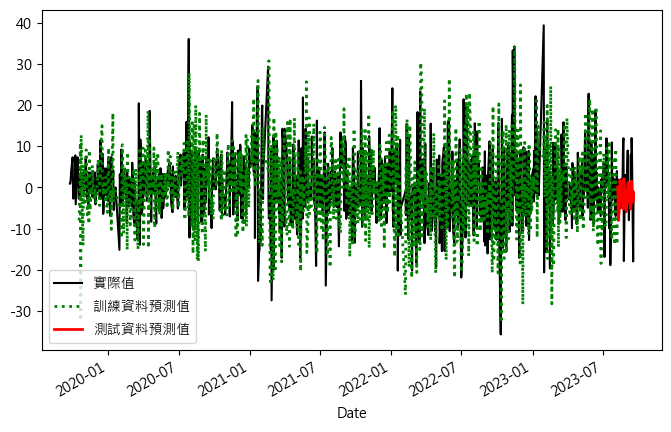

In [76]:
df_diff['diff'].plot(color='black', linestyle='-', label='實際值')
model_diff.fittedvalues.iloc[15:].plot(color='green', linestyle=':', lw=2, label='訓練資料預測值')
test_pred = pd.Series(data=pred.values, index=df_diff.index[X_train.shape[0]:])
test_pred.plot(figsize=(8, 5), color='red', lw=2, label='測試資料預測值')
plt.legend();

In [77]:
print(f'SARIMAX MSE = {(np.sum(model_diff.resid**2) / len(model_diff.resid)):.2f}')

SARIMAX MSE = 146.23


### 時間序列

In [78]:
date1 = pd.date_range(start=df.index[0], end=df.index[-1])
df_continue = pd.DataFrame(index=date1)
df_continue = df_continue.join(df)
df_continue = df_continue.fillna(method='ffill')
df_continue.head()

,Open,High,Low,Close,Adj Close,Volume
2019-09-23,264.0,264.0,263.0,264.0,241.250092,13093208.0
2019-09-24,263.5,265.5,262.0,265.0,242.163925,24244943.0
2019-09-25,262.5,266.0,262.0,266.0,243.077774,21003163.0
2019-09-26,269.0,269.5,266.5,268.0,244.905380,29940103.0
2019-09-27,271.5,272.5,271.0,272.0,248.560730,41235817.0


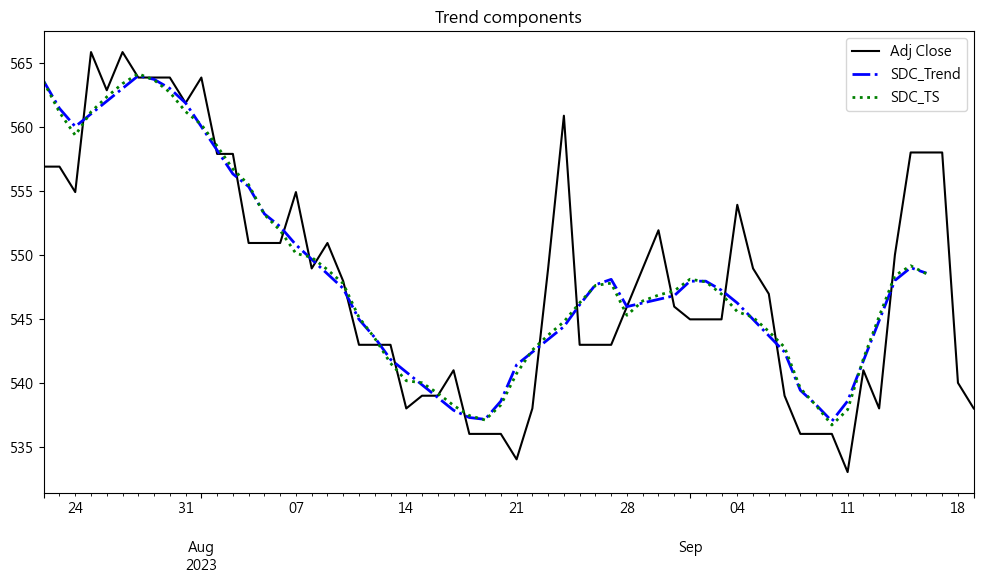

In [79]:
decomp = df_continue
s_dc = seasonal_decompose(decomp['Adj Close'], model='additive')
decomp['SDC_Seasonal'] = s_dc.seasonal
decomp['SDC_Trend'] = s_dc.trend
decomp['SDC_Error'] = s_dc.resid
decomp['SDC_TS'] = s_dc.trend + s_dc.seasonal


plt.title('Trend components')
decomp[-60:]['Adj Close'].plot(figsize=(12, 6), color='black', linestyle='-', legend='Adj Close')
decomp[-60:]['SDC_Trend'].plot(figsize=(12, 6), color='blue', linestyle='-.', lw=2, legend='SDC_Trend')
decomp[-60:]['SDC_TS'].plot(figsize=(12, 6), color='green', linestyle=':', lw=2, legend='TS');

### 效應分解(Decomposition)

* Observed 觀測實際值
* Trend 變化趨勢
* Seasonal 序列週期性
* Residual 殘差

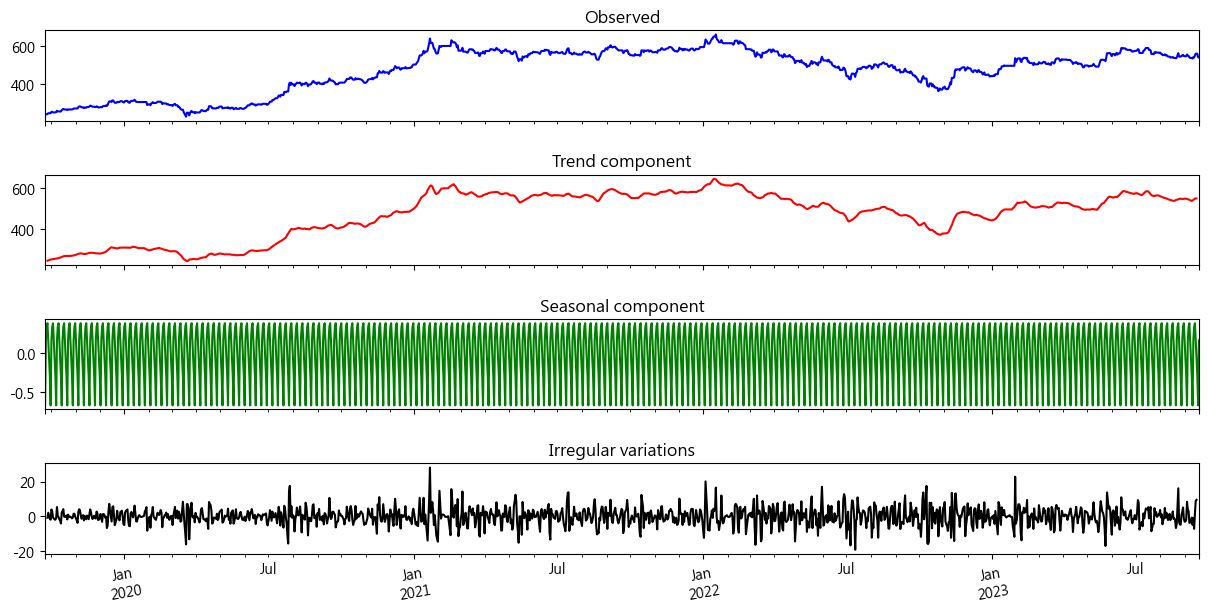

In [80]:
#Plot the original time series, trend, seasonal and random components
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(12, 6)

decomp['Adj Close'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Observed')

pd.Series(data=decomp['SDC_Trend'], index=decomp.index).plot(color='r', linestyle='-', ax=axarr[1])
axarr[1].set_title('Trend component')

pd.Series(data=decomp['SDC_Seasonal'], index=decomp.index).plot(color='g', linestyle='-', ax=axarr[2])
axarr[2].set_title('Seasonal component')

pd.Series(data=decomp['SDC_Error'], index=decomp.index).plot(color='k', linestyle='-', ax=axarr[3])
axarr[3].set_title('Irregular variations')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
fig=plt.xticks(rotation=10)

In [81]:
for _ in range(3,len(decomp)):
    if (decomp.iloc[_:_+1,6][0] == decomp.iloc[0:1,6][0])&(decomp.iloc[_+1:_+2,6][0] == decomp.iloc[1:2,6][0]) & (decomp.iloc[_+2:_+3,6][0] == decomp.iloc[2:3,6][0]):
        period_num = _
        break
period_num

7

<Figure size 640x480 with 0 Axes>

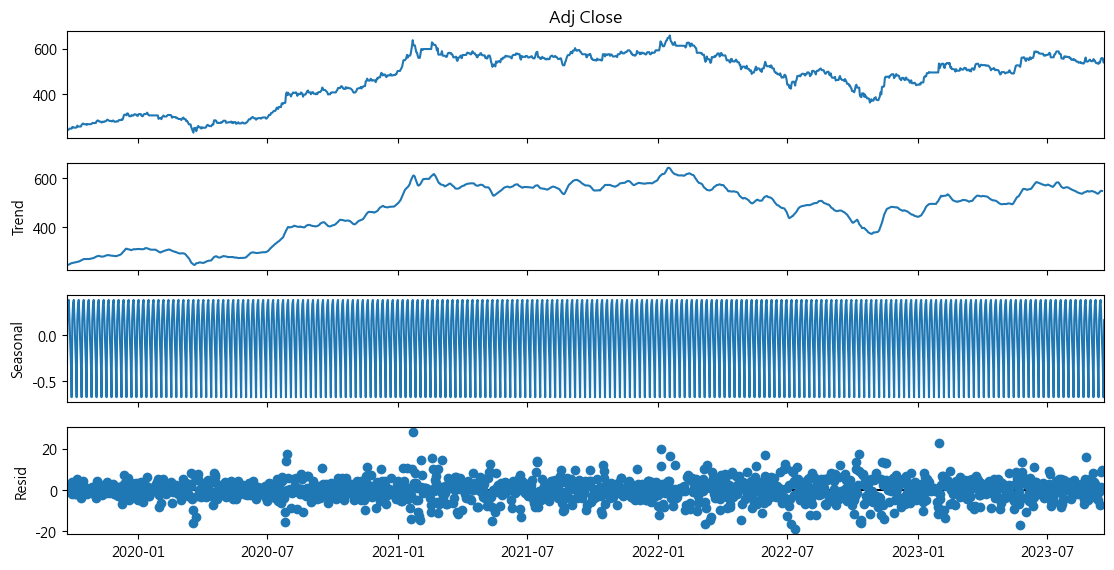

In [82]:
decomposition=seasonal_decompose(decomp['Adj Close'], model='additive')
fig=plt.figure()
fig=decomposition.plot()
fig.set_size_inches(12,6);

In [83]:
MSE = (decomp['SDC_Error']**2).sum() / decomp['SDC_Error'].shape[0]
'MSE=', MSE

('MSE=', 24.70042281125194)

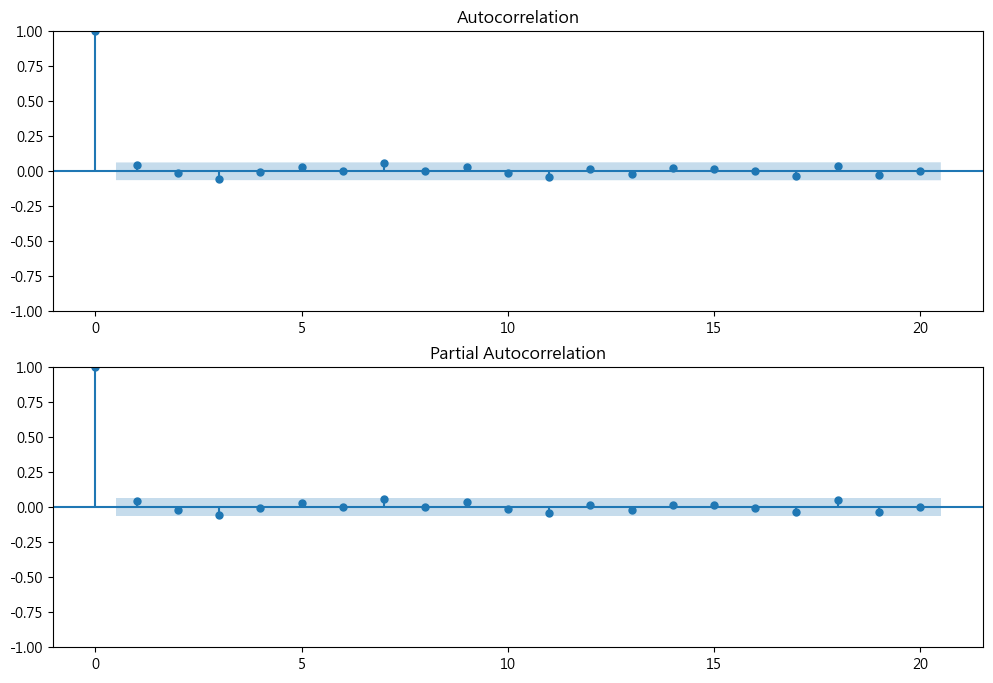

In [84]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig=sm.graphics.tsa.plot_acf(df_diff['diff'].iloc[period_num:],lags=20,ax=ax1)
ax2=fig.add_subplot(212)
fig=sm.graphics.tsa.plot_pacf(df_diff['diff'].iloc[period_num:],lags=20,ax=ax2)

### [SARIMA(p,d,q)x(P,D,Q)](https://zhuanlan.zhihu.com/p/157960700)

p: Linear combination lags of Y;order of the AR term.

d: order of differencing (d) in ARIMA model to make the time series stationary.

q:Linear combination lagged forecast errors; order of the MA term.


P= number of seasonal autoregressive terms;

D=number of seasonal differences

Q=number of seasonal moving-average terms

In [85]:
df_SARIMAX = df_diff.copy()
train=df_SARIMAX[:int(df_SARIMAX.shape[0]*0.9)]
test=df_SARIMAX[int(df_SARIMAX.shape[0]*0.9):]
mod=sm.tsa.statespace.SARIMAX(train['diff'],trend='n',order=(0,1,1),seasonal_order=(1,1,0,period_num))
results=mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               diff   No. Observations:                  873
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 7)   Log Likelihood               -3199.951
Date:                            Wed, 20 Sep 2023   AIC                           6405.902
Time:                                    08:50:46   BIC                           6420.190
Sample:                                         0   HQIC                          6411.371
                                            - 873                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      0.133     -7.536      0.000      -1.260      -0.740
ar.S.L7       -0.4830      0.023   

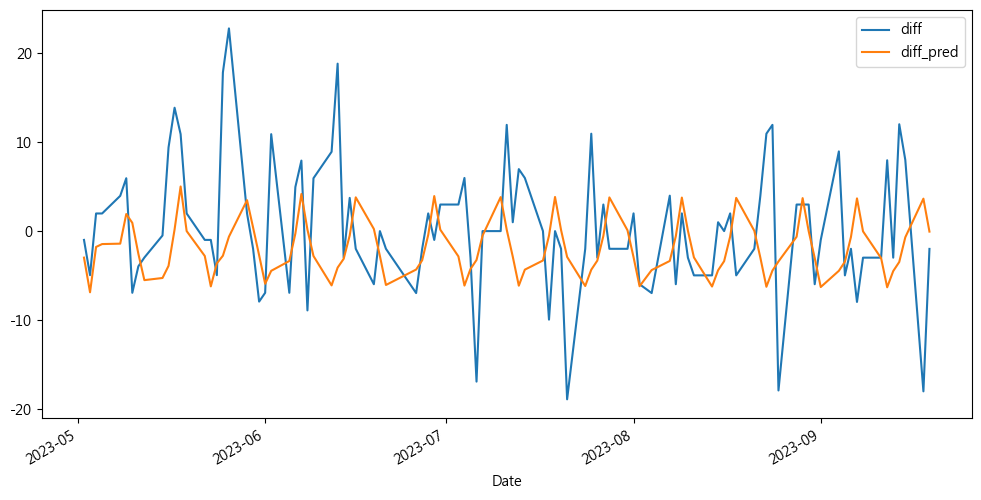

In [86]:
tmp = results.predict(start = int(df_SARIMAX.shape[0]*0.9)+1, end= df_SARIMAX.shape[0], dynamic= True).to_list()
test['diff_pred'] = tmp
test[['diff', 'diff_pred']].plot(figsize=(12, 6));

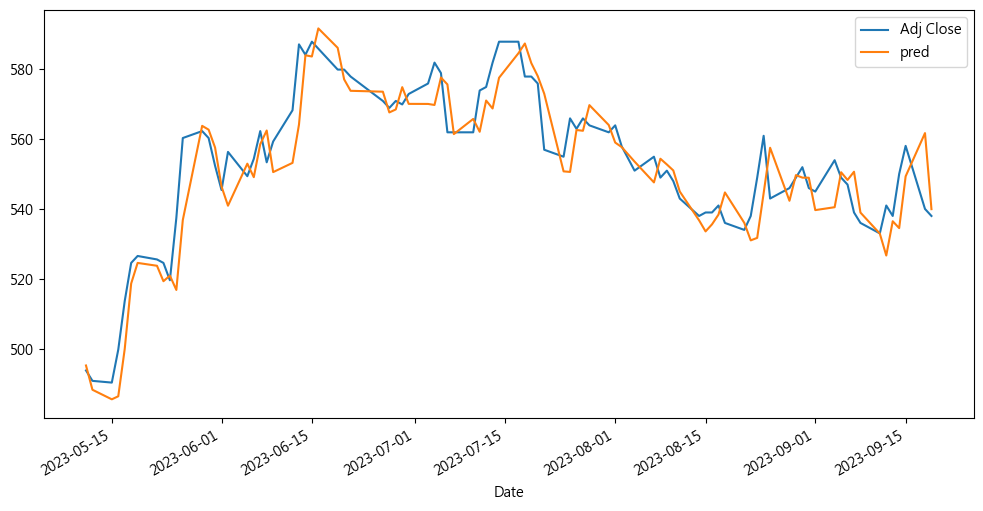

In [87]:
x, x_diff = test['Adj Close'].iloc[:], test['diff_pred'].iloc[:]
C=[]
for i in range(len(x)-1):
    c=x[i]+x_diff[i+1]
    C.append(c)
C=[0]*1+C
test['pred']=C
test[['Adj Close', 'pred']][period_num:].plot(figsize=(12, 6));

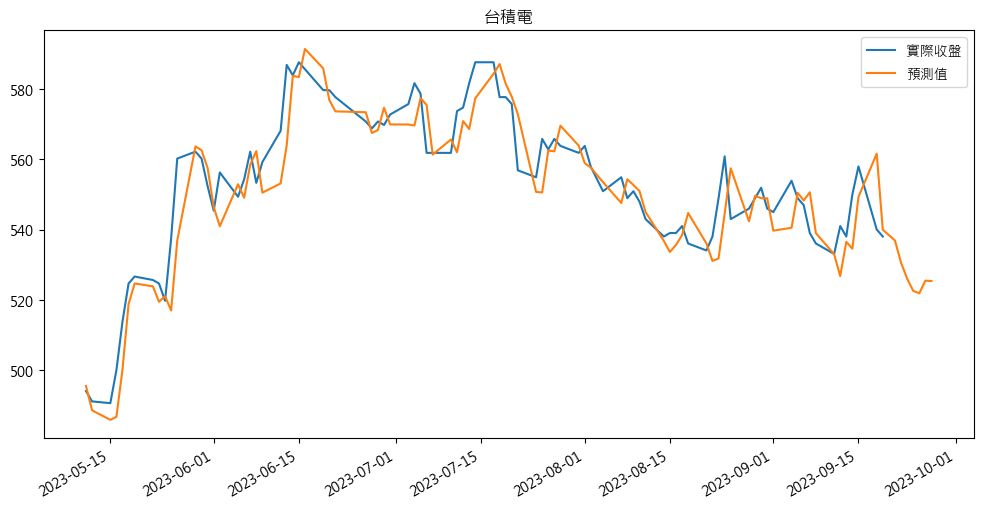

In [88]:
day_list = [(today + datetime.timedelta(days=i)).strftime('%Y-%m-%d') for i in range(1, period_num+1)]
pred_df = pd.DataFrame(columns=['Adj Close', 'diff', 'diff_pred','pred'], index = day_list)
last_price = test[-1:]['pred'].values[0]
tmp1 = results.predict(start = df_SARIMAX.shape[0]+1, end= df_SARIMAX.shape[0]+period_num, dynamic= True).to_list()
pred_df['diff_pred']=tmp1[-period_num:]
pred_df.iloc[0:1,3] = last_price + pred_df[0:1]['diff_pred'].values[0]
for i in range(1,len(pred_df)):
    pred_df.iloc[i:i+1,3] = pred_df.iloc[i-1]['pred'] + pred_df.iloc[i]['diff_pred']
test = pd.concat([test,pred_df],axis=0)
test.index = pd.to_datetime(test.index)
test.columns = ['實際收盤','diff','diff_pred','預測值']
test[['實際收盤', '預測值']][period_num:].plot(figsize=(12, 6),title=f'{stock_name}');